# Particle Mesh N-body Simulation

LPT accurately describes structure formation at early times and on large scales, but breaks down when particles begin to cross (shell-crossing). The Particle Mesh (PM) method integrates the full equations of motion using symplectic time-stepping on a grid.

This notebook compares the two available solvers and their correction kernels:

| Solver | Scheme | Reversible | Notes |
|--------|--------|-----------|-------|
| `EfficientDriftDoubleKick` | DKK | No | FastPM scheme, fewer force evaluations |
| `ReversibleDoubleKickDrift` | KKD | Yes | Needed for adjoint differentiation |

| Correction | Effect | Reversible |
|-----------|--------|------------|
| `NoCorrection` | Baseline PM | Yes |
| `PGDKernel` | Sharpens particle positions via potential gradient | No |
| `SharpeningKernel` | Boosts velocities for sub-grid structure | Yes |

## Setup

In [1]:
import os

os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION'] = '0.97'

import jax
import jax.numpy as jnp
import jax_cosmo as jc
import matplotlib.pyplot as plt

import fwd_model_tools as ffi

/home/wassim/micromamba/envs/ffi11/lib/python3.11/site-packages/jax_cosmo/__init__.py:2: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


## Initial Conditions and LPT Initialization

PM simulations start from LPT displacements and momenta at an early scale factor $a_0$. We use `lpt` with a **scalar** `scale_factor_spec` to get the particle state without painting.

In [2]:
key = jax.random.PRNGKey(0)
resolution = 128
mesh_size = (resolution,) * 3
box_size = (500.0, 500.0, 500.0)
nside = resolution
flatsky_npix = (resolution, resolution)
field_size = (10, 10)
nb_shells = 4
cosmo = ffi.Planck18()
ts = jnp.array([0.2 , 0.6, 1.0])

initial_field = ffi.gaussian_initial_conditions(
    key, mesh_size, box_size,
    cosmo=cosmo,
    nside=nside,
    flatsky_npix=flatsky_npix,
    field_size=field_size,
)

# LPT at early time to initialize PM
t0 = 0.1
dx, p = ffi.lpt(cosmo, initial_field, scale_factor_spec=t0, order=1, painting=ffi.PaintingOptions(target="particles"))
print(f"LPT initialized at a={t0}")
print(f"Displacement status: {dx.status}")

LPT initialized at a=0.1
Displacement status: FieldStatus.LPT1


## Solver Overview

Both solvers compose **Kick** (update momenta from forces) and **Drift** (update positions from momenta) operations:

- **DKK** (`EfficientDriftDoubleKick`): Drift-Kick-Kick ordering. Uses the FastPM time-stepping scheme with fewer force evaluations per step. Not time-reversible.
- **KKD** (`ReversibleDoubleKickDrift`): Kick-Kick-Drift ordering. Time-reversible, making it compatible with adjoint-based gradient computation through the ODE solve.

They are equivalent solvers the DKK does an initial Kick then a Drift double kick
The KKD solver does an intitial kick drift then every step is double kick drift (of the next step)

KKD is better for interpolation because the velocities at the end of the steps are the ones used to drift and in that case we can do the last drift (more info in @CLAUDE SOME other notebook)

dx array sharding in NoInterp: GSPMDSharding({replicated}, memory_kind=device)
Furthest shell is [4968.98551626 1678.54750668    0.        ] Mpc/h, box extends to 250.0 Mpc/h
Painting shell at comoving center 4968.985516259011 Mpc/h with width 3290.4380095818688 Mpc/h and shell index is 0


/home/wassim/micromamba/envs/ffi11/lib/python3.11/site-packages/jax/_src/debugging.py:201: UserWarning: 
                NoInterp does not support tiling.
                Your furthest shell is at 6614.20 Mpc/h,
                but your box only extends to 250.00 Mpc/h.
                Your simulations will run but will have artifacts for the far shells.
            
  debug_callback_p.impl(


Painting shell at comoving center 1678.547506677143 Mpc/h with width 3290.4380095818674 Mpc/h and shell index is 1
Painting shell at comoving center 0.0 Mpc/h with width 66.65700377241865 Mpc/h and shell index is 2
KKD output type: DensityField, shape: (3, 128, 128, 128)


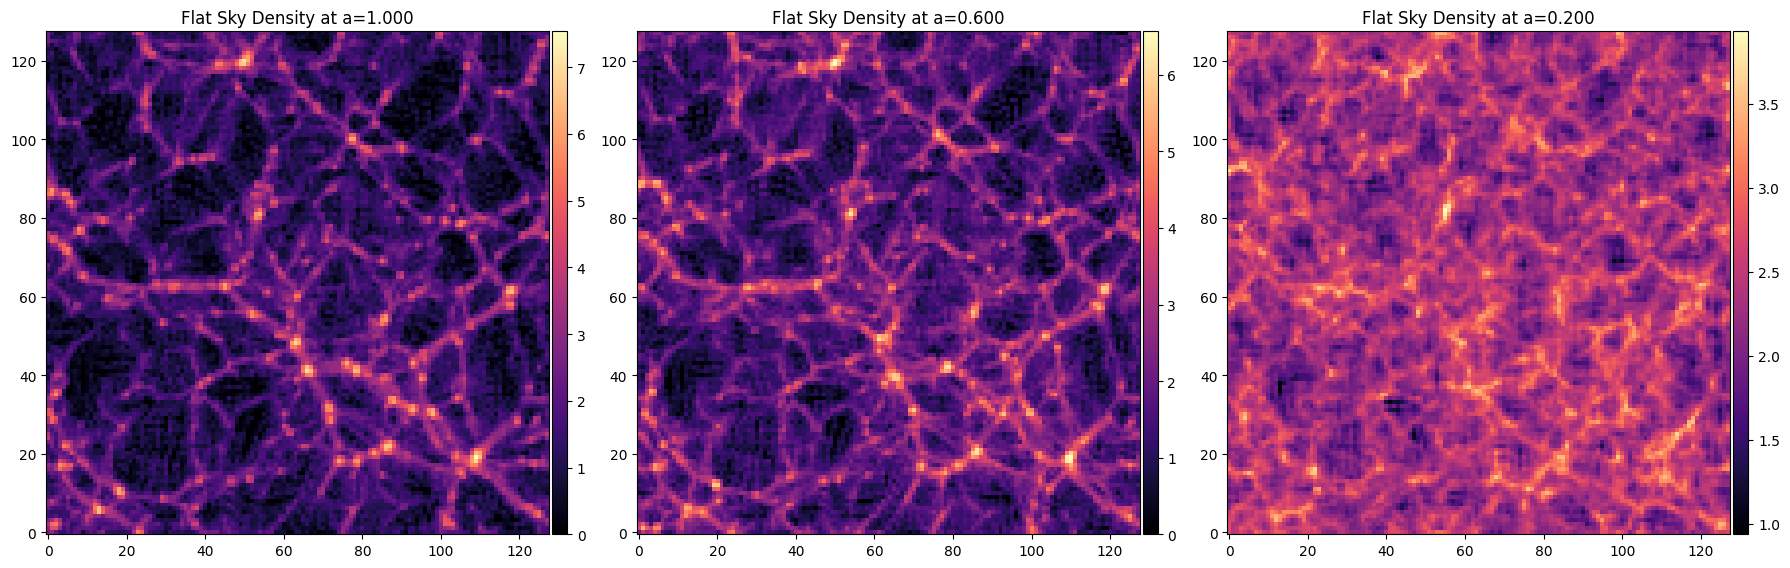

In [3]:
solver_kkd = ffi.ReversibleDoubleKickDrift(
    interp_kernel=ffi.NoInterp(painting=ffi.PaintingOptions(target="density")),
)

result_kkd = ffi.nbody(
    cosmo, dx, p,
    t1=1.0, dt0=0.05,
    ts=ts,
    solver=solver_kkd,
)
print(f"KKD output type: {type(result_kkd).__name__}, shape: {result_kkd.shape}")
result_kkd.project().apply_fn(jnp.log1p).show()

Notice the warning that you get. since the requested snapshots will be ouside the box we can see the 3D density fields or the particles but if you request any projection (flat sky or healpix) you will get empty or artifact corrputed maps

dx array sharding in NoInterp: GSPMDSharding({replicated}, memory_kind=device)
self.array sharding: GSPMDSharding({replicated}, memory_kind=device)
self.array sharding after cast: GSPMDSharding({replicated}, memory_kind=device)
data sharding before map: GSPMDSharding({replicated}, memory_kind=device)
positions sharding: GSPMDSharding({replicated}, memory_kind=device)
xy sharding: GSPMDSharding({replicated}, memory_kind=device)
dz sharding: GSPMDSharding({replicated}, memory_kind=device)
Furthest shell is [4968.98551626 1678.54750668    0.        ] Mpc/h, box extends to 250.0 Mpc/h
Painting shell at comoving center 4968.985516259011 Mpc/h with width 3290.4380095818688 Mpc/h and shell index is 0
Painting shell at comoving center 1678.547506677143 Mpc/h with width 3290.4380095818674 Mpc/h and shell index is 1
Painting shell at comoving center 0.0 Mpc/h with width 66.65700377241865 Mpc/h and shell index is 2
KKD output type: FlatDensity, shape: (3, 128, 128)


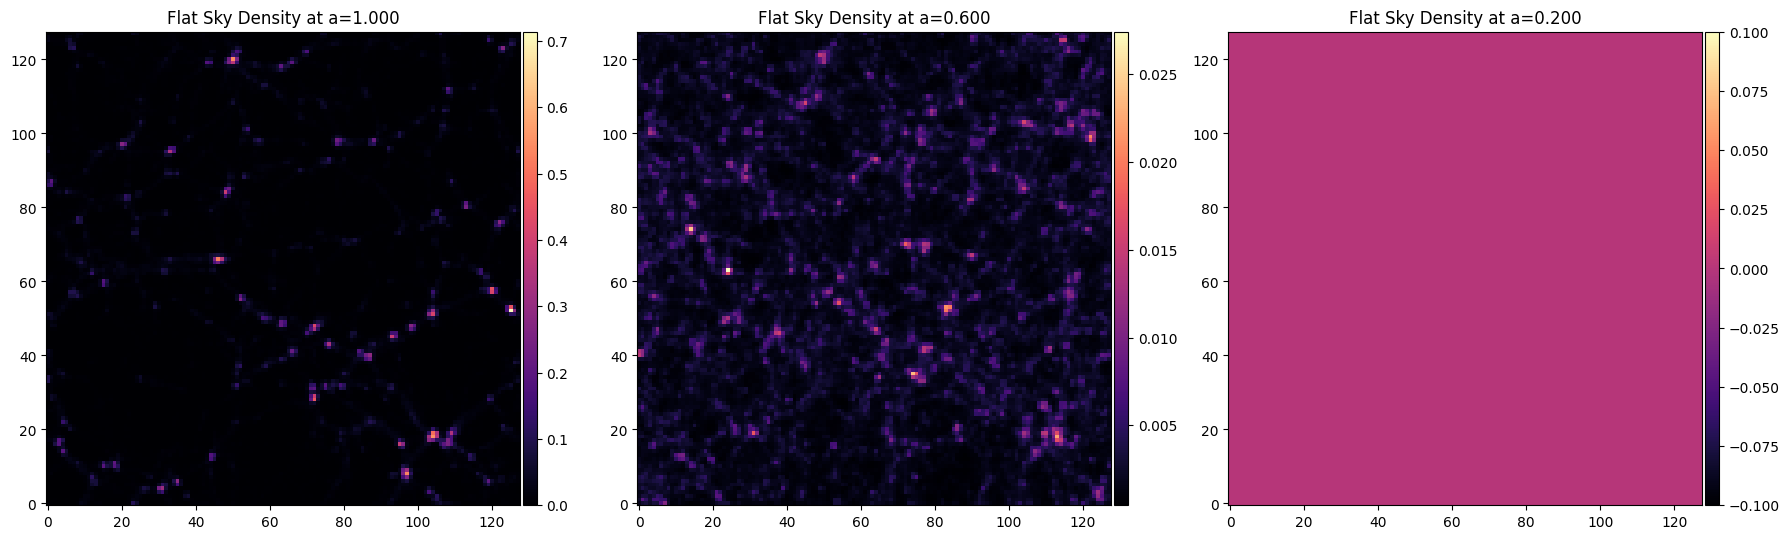

In [4]:
solver_kkd = ffi.ReversibleDoubleKickDrift(
    interp_kernel=ffi.NoInterp(painting=ffi.PaintingOptions(target="flat")),
)

result_kkd = ffi.nbody(
    cosmo, dx, p,
    t1=1.0, dt0=0.05,
    ts=ts,
    solver=solver_kkd,
)
print(f"KKD output type: {type(result_kkd).__name__}, shape: {result_kkd.shape}")
result_kkd.apply_fn(jnp.log1p).show()

Same thing happens to spherical maps altough the artifical might seem worse to the fact that painting outside the region can sometimes intersect with the corners of the box and create "circular" artifacts. In the flat sky case the artifacts are more "linear" and less visible but they are still there and they can be seen if you zoom in enough.

dx array sharding in NoInterp: GSPMDSharding({replicated}, memory_kind=device)
Furthest shell is [4968.98551626 1678.54750668    0.        ] Mpc/h, box extends to 250.0 Mpc/h
Painting shell at comoving center 4968.985516259011 Mpc/h with width 3290.4380095818688 Mpc/h and shell index is 0
Painting shell at comoving center 1678.547506677143 Mpc/h with width 3290.4380095818674 Mpc/h and shell index is 1
Painting shell at comoving center 0.0 Mpc/h with width 66.65700377241865 Mpc/h and shell index is 2
KKD output type: SphericalDensity, shape: (3, 196608)


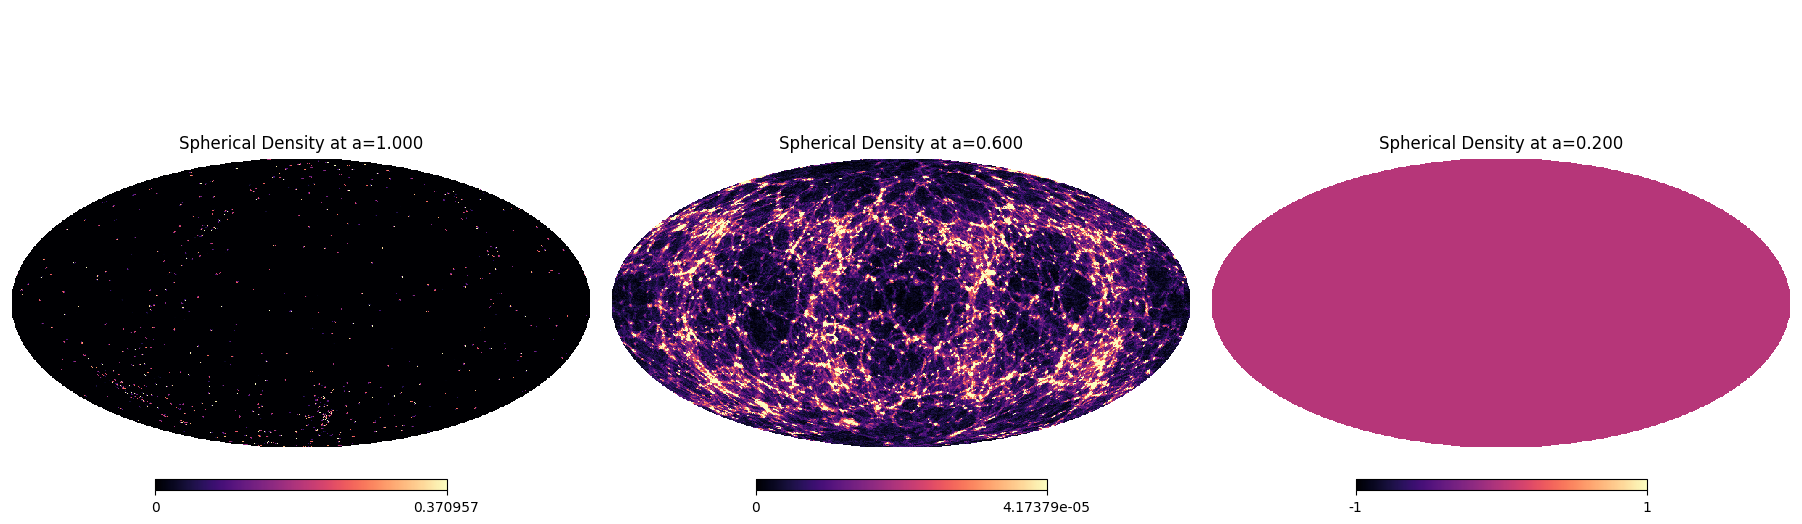

In [5]:
solver_kkd = ffi.ReversibleDoubleKickDrift(
    interp_kernel=ffi.NoInterp(painting=ffi.PaintingOptions(target="spherical")),
)

result_kkd = ffi.nbody(
    cosmo, dx, p,
    t1=1.0, dt0=0.05,
    ts=ts,
    solver=solver_kkd,
)
print(f"KKD output type: {type(result_kkd).__name__}, shape: {result_kkd.shape}")
result_kkd.apply_fn(jnp.log1p).show()

# Making a Correct simulation with a projected field

So a correct simulation must be inside the box or at least user some replication scheme (@CLAUDE SOME other notebook) to make sure that the painting is correct.
You must make sure that the furtherst redshift is inside your box or use the `nb_shells` argument instead of manually specifying the snapshots with `ts`. The `nb_shells` will make sure that the snapshots are equally spaced in comoving distance and that the furthest one is inside the box.

dx array sharding in NoInterp: GSPMDSharding({replicated}, memory_kind=device)
Furthest shell is [218.75 156.25  93.75  31.25] Mpc/h, box extends to 250.0 Mpc/h
Painting shell at comoving center 218.75 Mpc/h with width 62.5 Mpc/h and shell index is 0
Painting shell at comoving center 156.25 Mpc/h with width 62.5 Mpc/h and shell index is 1
Painting shell at comoving center 93.75 Mpc/h with width 62.5 Mpc/h and shell index is 2
Painting shell at comoving center 31.25 Mpc/h with width 62.5 Mpc/h and shell index is 3
KKD output type: SphericalDensity, shape: (4, 196608)


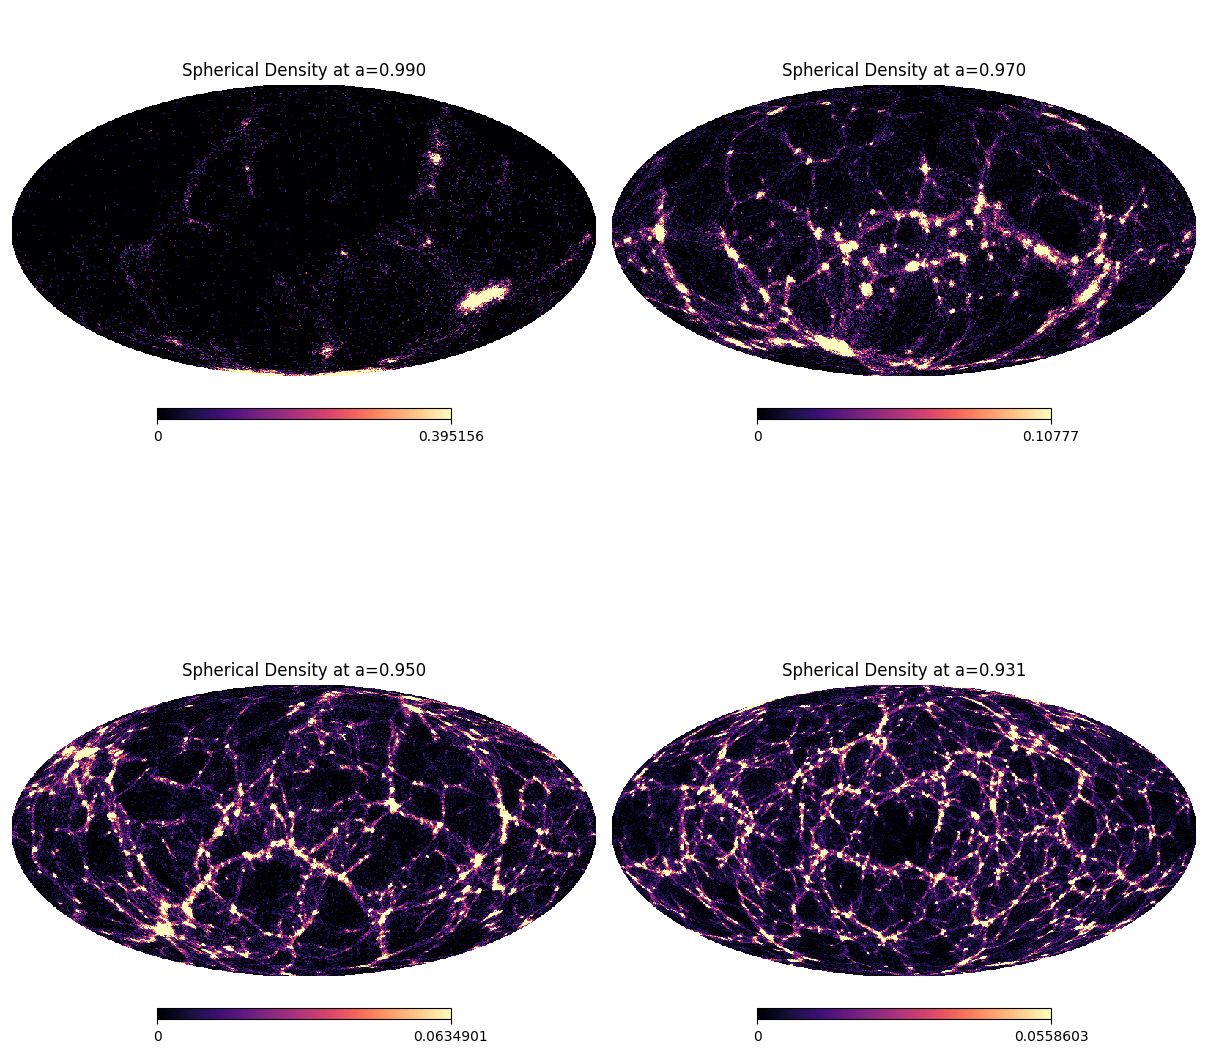

In [6]:
nb_shells = 4
solver_kkd = ffi.ReversibleDoubleKickDrift(
    interp_kernel=ffi.NoInterp(painting=ffi.PaintingOptions(target="spherical")),
)

result_kkd = ffi.nbody(
    cosmo, dx, p,
    t1=1.0, dt0=0.05,
    nb_shells=nb_shells,
    solver=solver_kkd,
)
print(f"KKD output type: {type(result_kkd).__name__}, shape: {result_kkd.shape}")
result_kkd.apply_fn(jnp.log1p).show(ncols=2)

In [7]:
print(f"The snapshots are at redshifts: {result_kkd.z_sources}") 
print(f"Maximum comoving distance of the shells: {result_kkd.max_comoving_radius:.2f} Mpc/h")
print(f"Maximum redshift of the shells: {jc.utils.a2z(jc.background.a_of_chi(cosmo ,result_kkd.max_comoving_radius)).squeeze():.2f}")

The snapshots are at redshifts: [0.0103161  0.03143381 0.05271965 0.07413277]
Maximum comoving distance of the shells: 250.00 Mpc/h
Maximum redshift of the shells: 0.09


This does not look very good because the snapshots are very close to the observer and to each other since the box we used so very small (500 Mpc/h) and the furthest redshift is around 0.2 but it is correct and there are no artifacts. If you want to see more structure you can increase the box size or decrease the furthest redshift is less than 0.1